# Weather forecast from [CEPAGRI](http://www.cpa.unicamp.br/)<sup>[1](#fn1)</sup>

In [ ]:
# https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
# https://www.ethanrosenthal.com/2018/03/22/time-series-for-scikit-learn-people-part2/
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

## Imports

In [2]:
import os
import requests
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
plt.rcParams['figure.figsize'] = [19, 9]

## Load file

In [3]:
url = 'https://www.ic.unicamp.br/~zanoni/cepagri/cepagri.csv'
response = requests.get(url)
with open(os.path.join("data", "cepagri.csv"), 'wb') as f:
    f.write(response.content)

In [4]:
data = pd.read_csv("data/cepagri.csv", header = None, sep=';')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
data.columns = ['date', 'temperature', 'wind', 'humidity', 'sensation']

In [6]:
data.date = pd.to_datetime(data.date, format='%d/%m/%Y-%H:%M', errors='coerce')

In [7]:
data = data.loc[(data.date < '2018-01-01') & (data.date >= '2015-1-1')]

In [8]:
data.temperature = pd.to_numeric(data.temperature, errors='coerce')
data['date_trunc'] = data['date'].apply(lambda s: datetime.date(s.year, s.month, 1))

In [9]:
data.dtypes

date           datetime64[ns]
temperature           float64
wind                  float64
humidity              float64
sensation             float64
date_trunc             object
dtype: object

In [10]:
data.shape

(156058, 6)

In [11]:
data.head()

,date,temperature,wind,humidity,sensation,date_trunc
42082,2015-01-01 00:00:00,22.7,22.2,92.2,21.6,2015-01-01
42083,2015-01-01 00:10:00,NaN,NaN,NaN,NaN,2015-01-01
42084,2015-01-01 00:20:00,22.6,23.1,92.5,21.5,2015-01-01
42085,2015-01-01 00:30:00,22.7,23.1,92.0,21.6,2015-01-01
42086,2015-01-01 00:40:00,22.8,22.7,91.3,21.7,2015-01-01


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


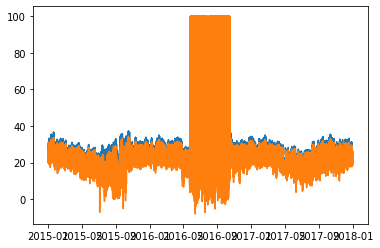

In [12]:
#plt.plot('date', 'temperature', data=data, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
#plt.plot('date', 'sensation', data=data, marker='', color='olive', linewidth=2)
# plt.plot('date', 'y3', data=data, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
#plt.legend()
plt.plot(data.date, data.temperature)
plt.plot(data.date, data.sensation)

## Data cleaning

First, we'll deal with `na`values. Let's simple remove it

In [13]:
data = data.dropna()

Now, let's remove spurious data.

In [14]:
data = data[data.sensation != 99.9]

In [15]:
data.shape

(154120, 6)

Text(0.5, 0, 'Date')

/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


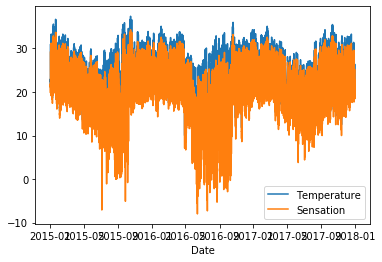

In [16]:
plt.plot(data.date, data.temperature)
plt.plot(data.date, data.sensation)
plt.legend(['Temperature', 'Sensation'])
plt.xlabel('Date')

Text(0.5, 0, 'Date')

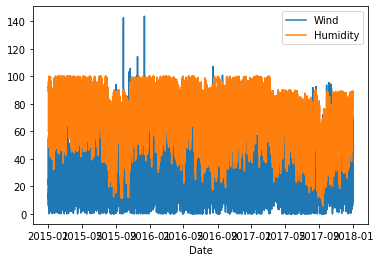

In [17]:
plt.plot('date', 'wind', data=data)
plt.plot('date', 'humidity', data=data)
plt.legend(['Wind', 'Humidity'])
plt.xlabel('Date')

## Psychrometrics analysis

Based on [[2]](#fn2), we have: 

| Relative Humidity (in %) | State |
|--------------------------|-----------|
| 0 to 11.9 | Emergency |
| 12 to 19.9 | Alert |
| 20 to 29.9 | Attention |

Let's display the frequency of days with these characteristics:

In [18]:
data['humidity_level'] = 'NORMAL'
data.loc[data['humidity'] < 30, 'humidity_level'] = 'WARNING'
data.loc[data['humidity'] < 20, 'humidity_level'] = 'ALERT'
data.loc[data['humidity'] < 12, 'humidity_level'] = 'EMERGENCY'
data.humidity_level = data.humidity_level.astype('category')

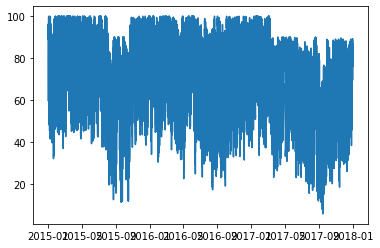

In [19]:
data['cat_code'] = data.humidity_level.astype('category').cat.codes.astype('int')
plt.plot('date', 'humidity', data=data)


## Beaufort scale

| Grau |     Designação      | Velocidade(km/h) |
| :--- | :-----------------: | ---------------: |
| 0    |        Calm         | <1              |
| 1    |       Light air     | 1 a 5            |
| 2    |     Light breeze    | 6 a 11           |
| 3    |     Gentle breeze	 | 12 a 19          |
| 4    |   Moderate breeze   | 20 a 28          |
| 5    |     Fresh breeze    | 29 a 38          |
| 6    |    Strong breeze    | 39 a 49          |
| 7    |     High wind       | 50 a 61          |
| 8    |      Fresh gale     | 62 a 74          |
| 9    | Strong/severe gale	 | 75 a 88          |
| 10   |     Storm           | 89 a 102         |
| 11   | Violent Storm       | 103 a 117        |
| 12   |   Hurricane force   | \>118            |

## Forecast

----
## Notes

<a name="fn1">1</a>: Centro de Pesquisas Meteorológicas e Climáticas Aplicadas à Agricultura. Está instalado no prédio da Embrapa Infomática Agropecuária, localizado no Campus da UNICAMP

<a name="fn2">2</a>: https://www.cgesp.org/v3/umidade-relativa-do-ar.jsp